# MNIST Digital Classification in Tensorflow

### Stan Liu

#### 29/07/2018

- #### 1.Introduction
- #### 2.Data preparation
    - 2.1 Load data and packages
    - 2.2 Check for null and missing values
    - 2.3 Nomolization
    - 2.4 Label encoding
    - 2.5 Split training and validation set
- #### 3.CNN building and training
    - 3.1 Define the model
    - 3.2 Set parameters
    - 3.3 Ensemble computation graph
    - 3.4 Set loss function and optimizer
    - 3.5 Model Training
- #### 4.Evaluate the model
    - 4.1 Training and validation curves
    - 4.2 Accuracy
    - 4.3 Confusion matrix
- #### 5.Prediction and submition
    - 5.1 Predict single digit
    - 5.2 Submit results

## 1. Introduction

This is a 5 layers Sequential Convolutional Neural Network for digits recognition trained on MNIST dataset. I choosed to build it with keras API (Tensorflow backend) which is very intuitive. Firstly, I will prepare the data (handwritten digits images) then i will focus on the CNN modeling and evaluation.

I achieved 97.671% of accuracy with this CNN trained in 20min on a double CPU (i5-5200U). For those who have a >= 3.0 GPU capabilites (from GTX 650 - to recent GPUs), you can use tensorflow-gpu with keras. Computation will be much much faster !!!

For computational reasons, i set the number of steps (epochs) to 2, if you want to achieve 99+% of accuracy set it to a larger number.

This Notebook follows three main parts:

The data preparation
The CNN modeling and evaluation
The results prediction and submission

## 2. Data preparation

### 2.1 Load data and packages

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import itertools
#from tensorflow.image import ResizeMethod

np.random.seed(1)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

sns.set(style='white', context='notebook', palette='deep')

In [4]:
# Load the data
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

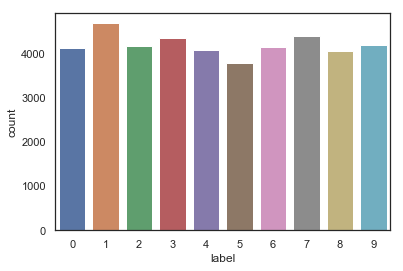

In [5]:
Y_train = train['label']

# Drop 'label' column
X_train = train.drop(labels = ['label'], axis = 1)

# Free some place
del train

g = sns.countplot(Y_train)

Y_train.value_counts()

Here we find there's no imbalance problem. Each kind of label counts similarly

### 2.2 Check for null and missing values

In [6]:
# Check the data
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [7]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

There is no missing values in the train and test dataset. So we can safely go ahead

### 2.3 Normalization

Perform a greyscale normalization to reduce the effect of illumination's differences.

In [8]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

# We retract the values of X_Train and test, obtaining np array
X_train = X_train.values
test = test.values
Y_train = Y_train.values

### 2.4 Label encoding

In [9]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = pd.get_dummies(Y_train).values

### 2.5 Split training and validation set

In [10]:
# Set the random seed
random_seed = 2

In [11]:
# Split the train and the validation set for fitting
X_train_input, X_val_input, Y_train_input, Y_val_input = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

Here to split the train set in two parts : a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model.

Since we have 42 000 training images of balanced labels (see 2.1 Load data), a random split of the train set doesn't cause some labels to be over represented in the validation set. 

We can get a better sense for one of these examples by visualising the image and looking at the label.

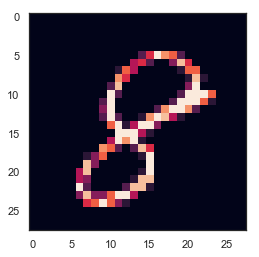

In [12]:
# Some examples
expl = plt.imshow(X_train_input[0].reshape(28,28))

## 3. CNN building and training

### 3.1 Define the model

I used the Tensorflow, where you have to define and build the complete computation graph before training start.

Let's start from the input. We first need to reshape the input X into a tensor X1 with a shape ( ?, 28, 28, 1 ) so that it can be filtered.

Then the first important layer is the convolutional (tf.nn.conv2d) layer. It is like a set of learnable filters. I choosed to set 24 filters the first convolutional (tf.nn.conv2d) layer. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image.

The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

The second important layer in CNN is the pooling (tf.layers.max_pooling2d) layer. This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. Here I carefully choose the pooling size (i.e the area size pooled each time) to be small. 

Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.

Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network.

The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

In the end i used the features in two fully-connected (Dense) layers which is just artificial an neural networks (ANN) classifier. In the last layer(Dense(10,activation="softmax")) the net outputs distribution of probability of each class.

### 3.2 Set parameters

In [13]:
# We first need to set a new conputation graph
tf.reset_default_graph()

# On the computation graph, we first need to define the paramaters

# Creat a standard API for 2d arrays 
# We then define the inuts
X = tf.placeholder(shape=(None, 784), dtype=tf.float32)
Y = tf.placeholder(shape=(None, 10), dtype=tf.float32)
keep_prob = tf.placeholder_with_default(tf.constant(0.75), shape=(), name="keep_prob")
# Here we use place holder in order to prevent the error input. If there is no input, tensorflow will find and use the value in the placeholder


# Model parameters

# Filters and rectify term for the first convolutional layer
F1 = tf.get_variable("F1", shape=(5, 5, 1, 32))
b1 = tf.get_variable("b1", shape=(28, 28, 32))
# Filters and rectify term for the second convolutional layer
F2 = tf.get_variable("F2", shape=(5, 5, 32, 32))
b2 = tf.get_variable("b2", shape=(14, 14, 32))
# Filters and rectify term for the third convolutional layer
F3 = tf.get_variable("F3", shape=(5, 5, 32, 24))
b3 = tf.get_variable("b3", shape=(7, 7, 24))
# The weight and rectify term for hidden layer
W_hidden = tf.get_variable("W_hidden", shape=(7 * 7 * 24, 200))
b_hidden = tf.get_variable("b_hidden", shape=(200))
# The weight and rectify term for output layer
W_out = tf.get_variable("W_out", shape=(200, 10))
b_out = tf.get_variable("b_out", shape=(10))



### 3.3 Ensemble computation graph

In [14]:
# Set the CNN model 
# My CNN architechture is In -> [Conv2D->relu -> MaxPool2D]*2 -> Conv2D->relu -> Flatten -> Dropout -> Dense -> Out

# Build the model
X1 = tf.reshape(X, (-1, 28, 28, 1))

# First convolutional and maxpooling layer
conv2D_1 = tf.nn.relu(tf.nn.conv2d(X1, F1, strides=(1, 1, 1, 1), padding='SAME') + b1)
X2 = tf.layers.max_pooling2d(conv2D_1, pool_size=(2, 2), strides=(2, 2), padding='VALID')

# Second convolutional and maxpooling layer
conv2D_2 = tf.nn.relu(tf.nn.conv2d(X2, F2, strides=(1, 1, 1, 1), padding='SAME') + b2)
X3 = tf.layers.max_pooling2d(conv2D_2, pool_size=(2, 2), strides=(2, 2), padding='VALID')

# Third convolutional layer
X4 = tf.nn.relu(tf.nn.conv2d(X3, F3, strides=(1, 1, 1, 1), padding='SAME') + b3)

# Flatten layer
Flatten_layer = tf.reshape(X4, (-1, 7 * 7 * 24))

# Hidden layer
hidden_layer = tf.nn.dropout(tf.matmul(Flatten_layer, W_hidden) + b_hidden, keep_prob=keep_prob)

# Output layer
prediction = tf.nn.softmax(tf.matmul(hidden_layer, W_out) + b_out, axis=1)

#For metrics and hypterparameter justification
match = tf.equal(tf.argmax(prediction, axis=1), tf.argmax(Y, axis=1))
accuracy = tf.reduce_mean(tf.cast(match, tf.float32))

### 3.4 Set loss function and optimizer

Once our layers are added to the model, we need to set up a score function, a loss function and an optimisation algorithm.

We define the loss function to measure how poorly our model performs on images with known labels. It is the error rate between the oberved labels and the predicted ones. We use a specific form for categorical classifications (>2 classes) called the "categorical_crossentropy".

The most important function is the optimizer. This function will iteratively improve parameters (filters kernel values, weights and bias of neurons ...) in order to minimise the loss.

I choosed Adam (with global learning rate as 0.001), it is a very effective optimizer. The Adam update adjusts the Adagrad method in a very simple way in an attempt to reduce its aggressive, monotonically decreasing learning rate. We could also have used Stochastic Gradient Descent ('sgd') optimizer, but it is slower than Adam.

The metric function "accuracy" is used is to evaluate the performance our model. This metric function is similar to the loss function, except that the results from the metric evaluation are not used when training the model (only for evaluation).

In [15]:
# The loss function
cross_entropy = tf.reduce_mean(tf.reduce_sum(-Y * tf.log(prediction), axis=1))
# Set optimizer
optimizer = tf.train.AdamOptimizer(0.001)
# Plug the loss function in the optimizer
train_step = optimizer.minimize(cross_entropy)

### 3.5 Model Training

In [16]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)


#test_data_size = len(mnist.test.labels)
batch_size = 100
train_ce_curve = []
validation_ce_curve = []
train_accuracy_curve = []
validation_accuracy_curve = []

for i in range(378):
    
    steps = (i + 1) * batch_size
    train_inputs = {X: X_train_input[i*batch_size:steps], Y: Y_train_input[i*batch_size:steps]}
    sess.run(train_step, feed_dict=train_inputs)
    
    if steps % 200 == 0:  # Print some stats every 200 images processed.
        # Train metrics
        current_train_accuracy, current_train_ce = sess.run([accuracy, cross_entropy], feed_dict=train_inputs)
        # Validation metrics. Just record validation metrics, if you want to use validation error to control stop, do it here.
        validation_inputs = {X: X_val_input, Y: Y_val_input, keep_prob: 1.0}
        current_validation_accuracy, current_validation_ce = sess.run([accuracy, cross_entropy], feed_dict=validation_inputs)
                
        train_ce_curve.append(current_train_ce)
        validation_ce_curve.append(current_validation_ce)
        train_accuracy_curve.append(current_train_accuracy)
        validation_accuracy_curve.append(current_validation_accuracy)
        
        
        if steps % 1000 == 0:
            print("%d images processed..." % steps)

1000 images processed...
2000 images processed...
3000 images processed...
4000 images processed...
5000 images processed...
6000 images processed...
7000 images processed...
8000 images processed...
9000 images processed...
10000 images processed...
11000 images processed...
12000 images processed...
13000 images processed...
14000 images processed...
15000 images processed...
16000 images processed...
17000 images processed...
18000 images processed...
19000 images processed...
20000 images processed...
21000 images processed...
22000 images processed...
23000 images processed...
24000 images processed...
25000 images processed...
26000 images processed...
27000 images processed...
28000 images processed...
29000 images processed...
30000 images processed...
31000 images processed...
32000 images processed...
33000 images processed...
34000 images processed...
35000 images processed...
36000 images processed...
37000 images processed...


## 4. Evaluate the model

### 4.1 Training and validation curves

The code below is for plotting loss and accuracy curves for training and validation.

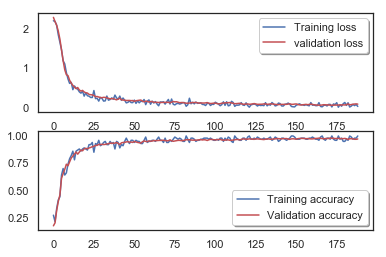

In [17]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(train_ce_curve, color='b', label="Training loss")
ax[0].plot(validation_ce_curve, color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(train_accuracy_curve, color='b', label="Training accuracy")
ax[1].plot(validation_accuracy_curve, color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### 4.2 Accuracy

The model reaches almost 98% (97.6+%) accuracy on the validation dataset. The validation accuracy is greater than the training accuracy almost evry time during the training. That means that our model kind of overfit the training set.

In [18]:
training_inputs = {X: X_train_input, Y: Y_train_input, keep_prob: 1.0}
accuracy_training = sess.run(accuracy, feed_dict=training_inputs)
print("The final accuracy on training set is : {}".format(accuracy_training))

val_inputs = {X: X_val_input, Y: Y_val_input, keep_prob: 1.0}
accuracy_val = sess.run(accuracy, feed_dict=val_inputs)
print("The final accuracy on validation set is : {}".format(accuracy_val))

The final accuracy on training set is : 0.9786243438720703
The final accuracy on validation set is : 0.9721428751945496


### 4.3 Confusion matrix

Confusion matrix can be very helpfull to see your model drawbacks.

Here I plot the confusion matrix of the validation results.

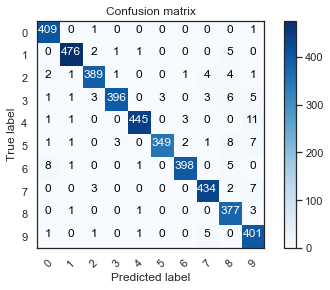

In [19]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = sess.run(prediction, feed_dict={X: X_val_input})
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val_input,axis = 1) 
# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

However, it seems that our CNN has some little troubles with the 8 and 9 digits, they are misclassified as 3. Sometime it is very difficult to catch the difference between 8 or 9 and 9 when curves are smooth.

Let's investigate for errors.

I want to see the most important errors . For that purpose i need to get the difference between the probabilities of real value and the predicted ones in the results.

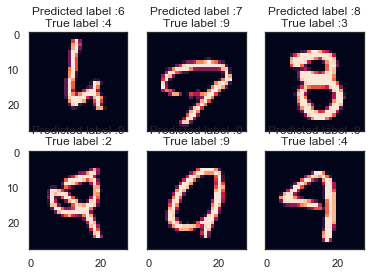

In [20]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val_input[errors]

def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels """
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

## 5. prediction and submission

In [21]:
# predict results
test_inputs = {X: test, keep_prob: 1.0}
results = sess.run(prediction, feed_dict=test_inputs)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")

#Submit the prediction
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("cnn_mnist_datagen.csv",index=False)